#UNZIPPING SOURCE FILE


In [ ]:
!unzip /content/log-data.csv.zip -d /content/log.csv #unzipping the log file

unzip:  cannot find or open /content/log-data.csv.zip, /content/log-data.csv.zip.zip or /content/log-data.csv.zip.ZIP.


In [ ]:
!tar -xvf /content/classifier-data.tar.gz #unzipping the classifier file

consolidated-metrics.csv


# Loading Dependencies

In [ ]:
#Loading Dependencies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")

figure(figsize=(18, 10), dpi=80)

<Figure size 1440x800 with 0 Axes>

<Figure size 1440x800 with 0 Axes>

# Data Exploration and Interpolation



In [165]:
df_cm=pd.read_csv("/content/consolidated-metrics.csv") #Loading data

In [ ]:
df_cm.shape #checking shape

(4294, 97)

In [133]:
pd.set_option('display.max_rows', 101, 'display.max_columns', 101) 

In [166]:
df_cm.isna().any()  #checking for Null Values

timestamp                                                       True
apiserver_current_inflight_requests                             True
apiserver_request_latencies_summary                             True
apiserver_response_sizes_sum                                    True
apiserver_storage_transformation_latencies_microseconds_sum     True
aws_cpu_utilization                                            False
aws_ec2_cpuutilization_average                                  True
aws_ec2_network_out_average                                     True
aws_network_out                                                 True
cgroup_manager_operation_rate                                   True
container_cpu_cfs_throttled_seconds_total                      False
container_fs_inodes_free                                       False
container_fs_usage_bytes                                       False
container_fs_writes_total                                      False
container_memory_cache            

In [167]:
df_cm['status'].unique()  #Unqiue values in target class

array(['NORMAL', 'CPU_BURN_KANBAN_API_GATEWAY',
       'NETWORK_DELAY_KANBAN_API_GATEWAY', nan,
       'NETWORK_DELAY_KANBAN_COMMAND_SERVICE',
       'POD_KILL_KANBAN_API_GATEWAY'], dtype=object)

In [168]:
df_cm=df_cm.dropna(subset=['status']) #Dropping NaN from status

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

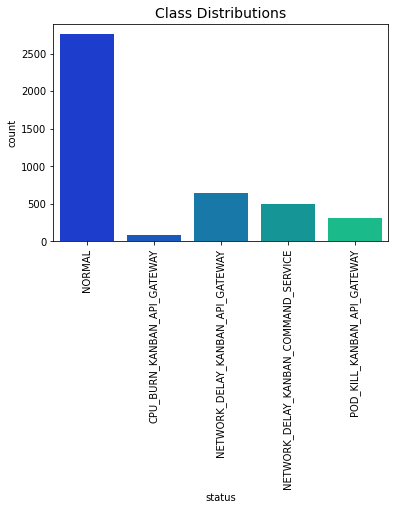

In [160]:
sns.countplot('status', data=df_cm, palette="winter")   #Checking class distribution
plt.title('Class Distributions', fontsize=14)
plt.xticks(rotation=90)

In [ ]:
#inteporlation

In [218]:
df_cm.describe #Getting insights

<bound method NDFrame.describe of                 timestamp  apiserver_current_inflight_requests  \
0     2020-09-18 21:45:03                             0.008333   
1     2020-09-18 21:46:03                             0.008333   
2     2020-09-18 21:47:03                             0.008333   
3     2020-09-18 21:48:03                             0.016138   
4     2020-09-18 21:49:03                             0.020305   
...                   ...                                  ...   
4289  2020-09-19 17:57:13                             0.008333   
4290  2020-09-19 17:58:13                             0.007640   
4291  2020-09-19 17:59:13                             0.013893   
4292  2020-09-19 18:00:13                             0.011113   
4293  2020-09-19 18:01:13                             0.011113   

      apiserver_request_latencies_summary  apiserver_response_sizes_sum  \
0                            4.775001e+06                   6871.300000   
1                      

In [ ]:
df_cm.dtypes #Checking data types

timestamp                                                       object
apiserver_current_inflight_requests                            float64
apiserver_request_latencies_summary                            float64
apiserver_response_sizes_sum                                   float64
apiserver_storage_transformation_latencies_microseconds_sum    float64
aws_cpu_utilization                                            float64
aws_ec2_cpuutilization_average                                 float64
aws_ec2_network_out_average                                    float64
aws_network_out                                                float64
cgroup_manager_operation_rate                                  float64
container_cpu_cfs_throttled_seconds_total                      float64
container_fs_inodes_free                                       float64
container_fs_usage_bytes                                       float64
container_fs_writes_total                                      float64
contai

In [169]:
df_cm_plot=df_cm.iloc[:,1:-1]  #Eliminating timestamp and status columns
cols=df_cm_plot.columns #Getting columns

Plotting Histogram to see how the attributes are distributed 

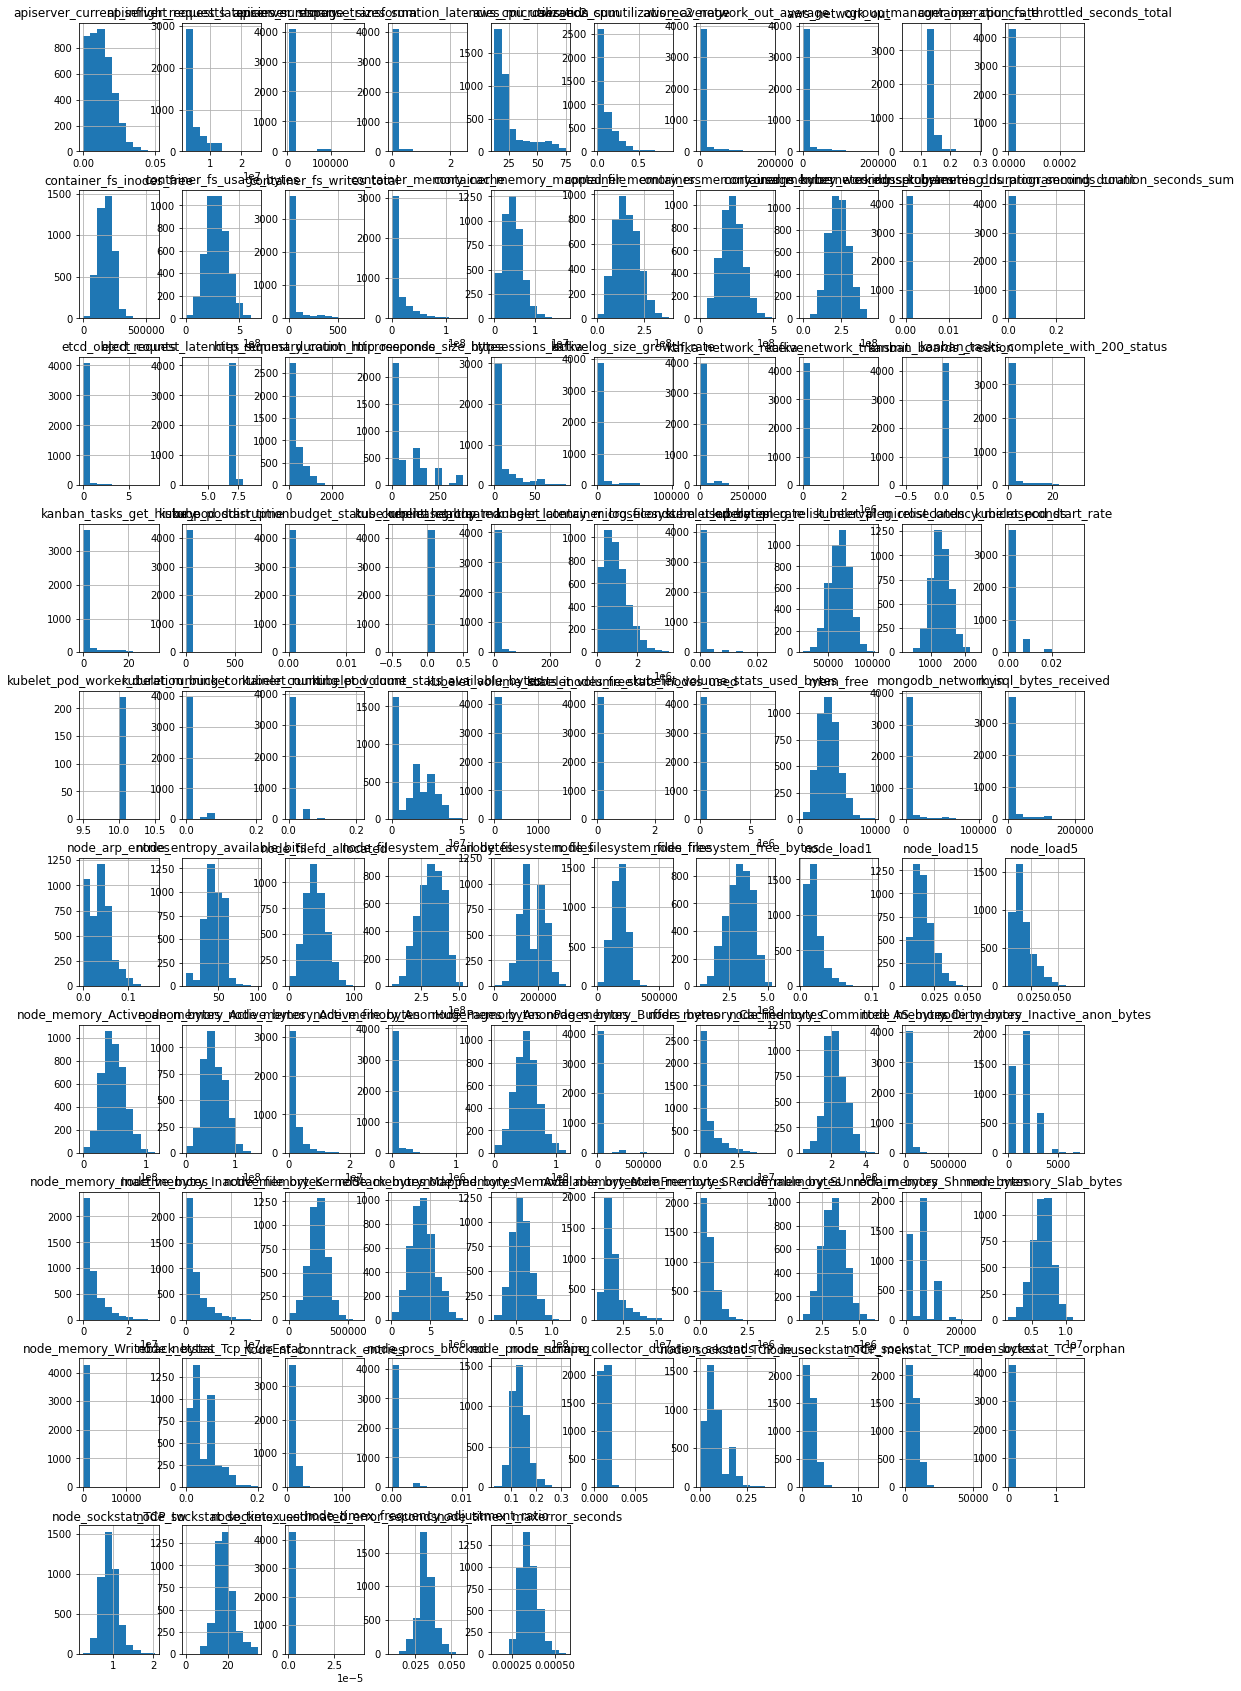

In [ ]:
fig = plt.figure(figsize = (18,30)) 
ax = fig.gca()
df_cm_plot.hist(ax = ax)
plt.tight_layout()
plt.show()

Plotting each attribute to see how the values are distributed. This is mostly done to understand which interpolation works best.

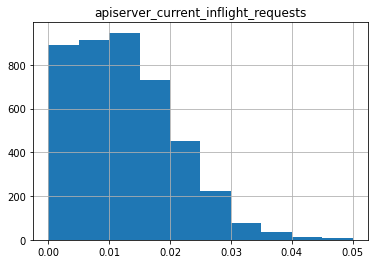

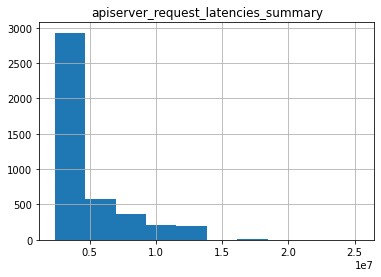

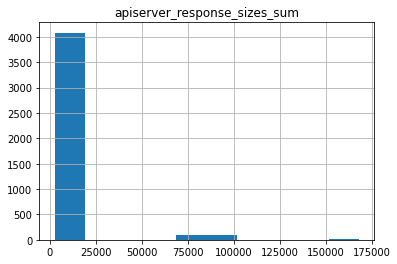

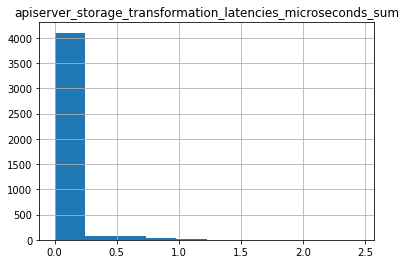

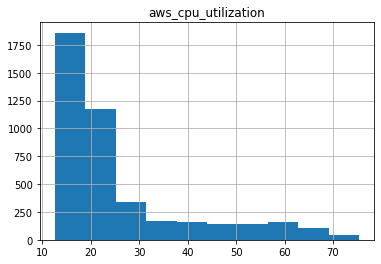

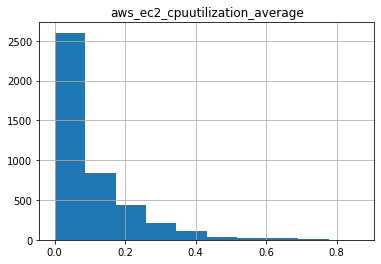

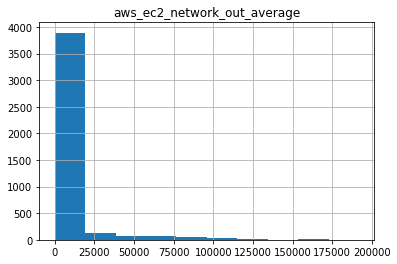

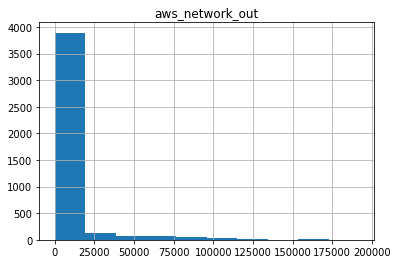

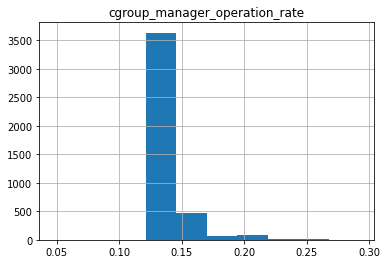

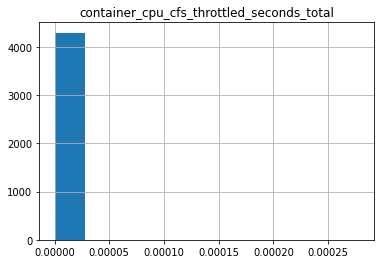

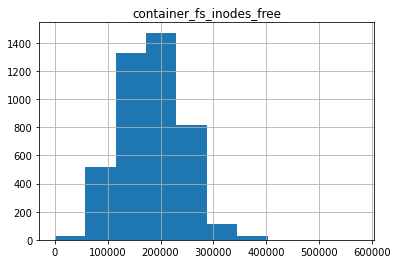

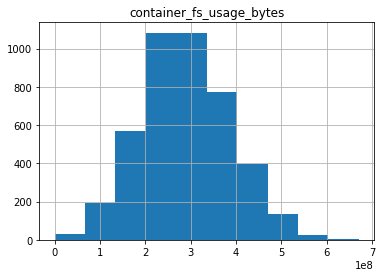

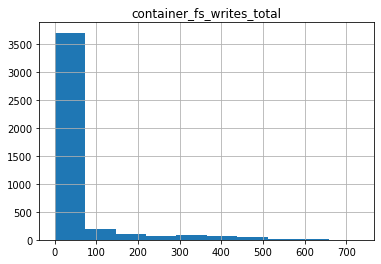

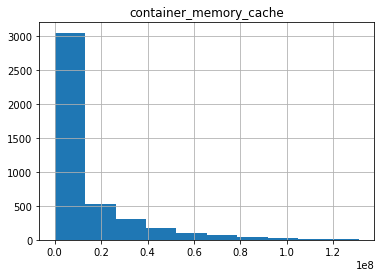

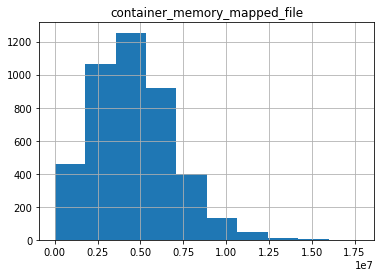

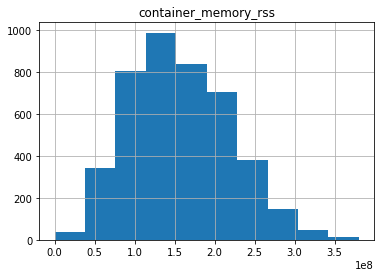

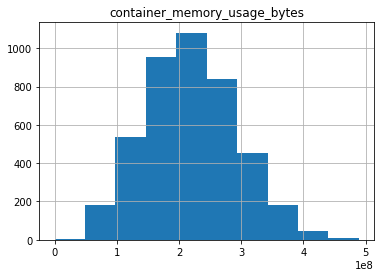

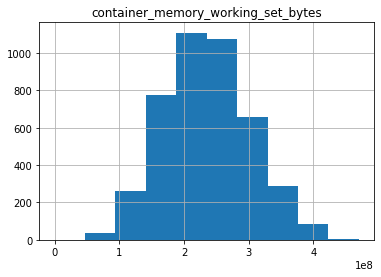

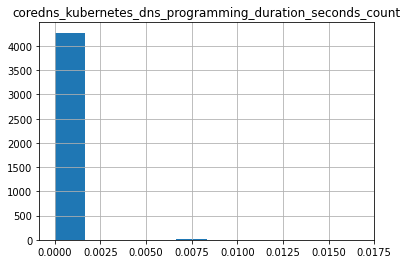

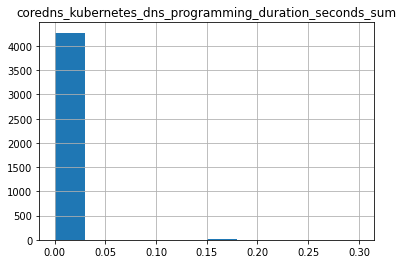

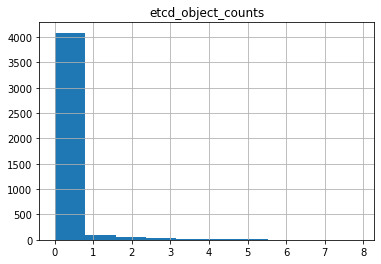

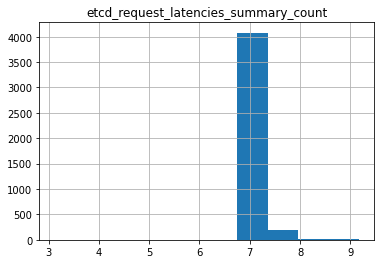

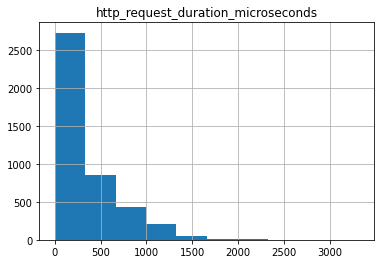

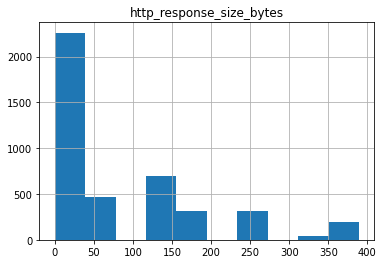

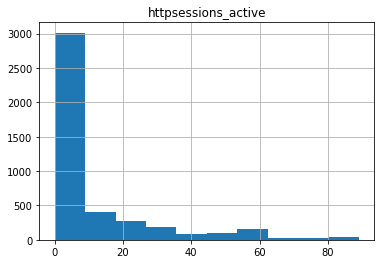

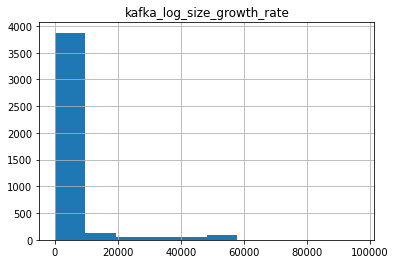

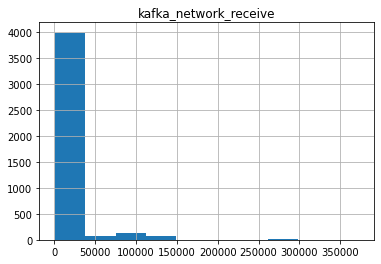

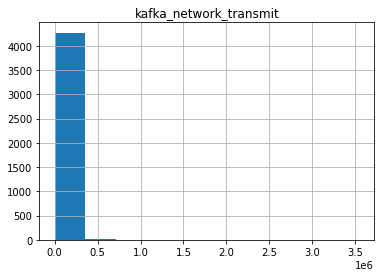

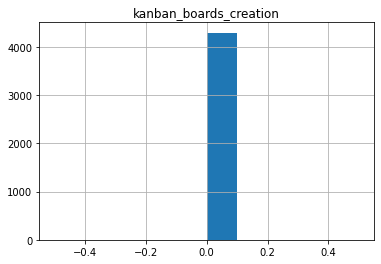

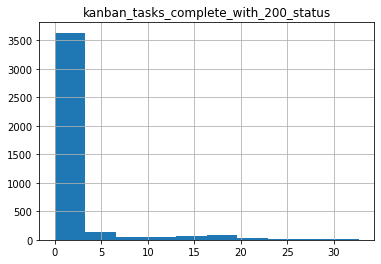

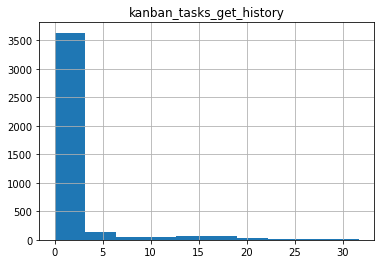

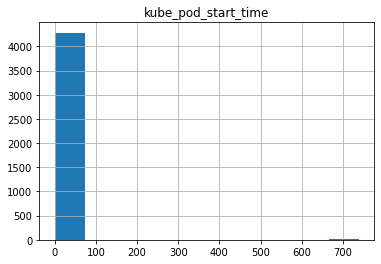

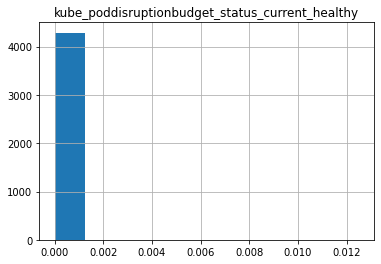

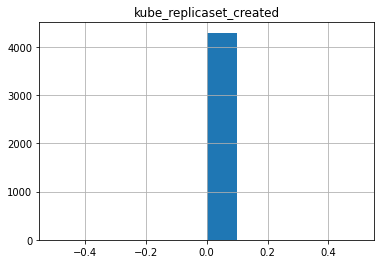

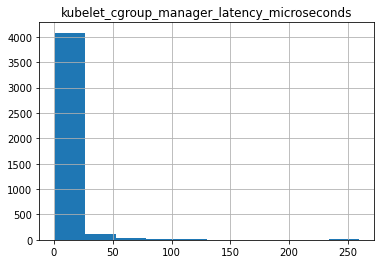

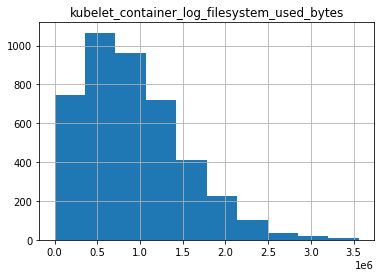

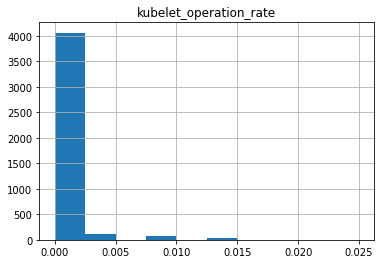

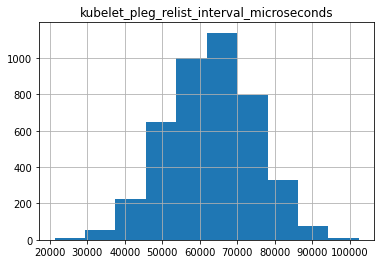

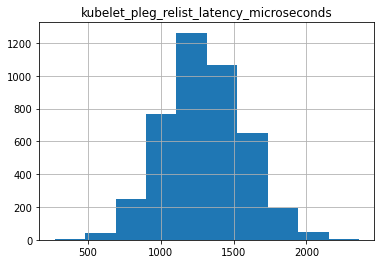

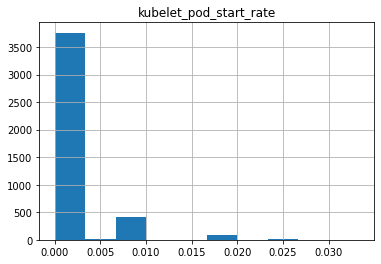

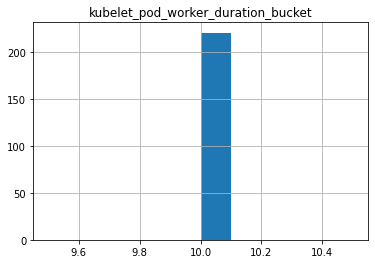

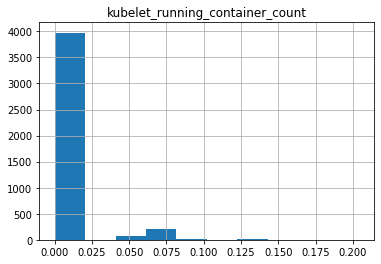

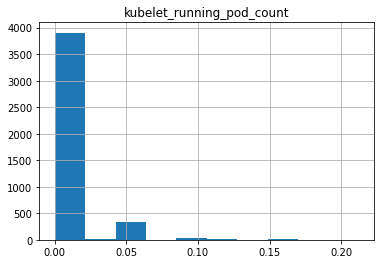

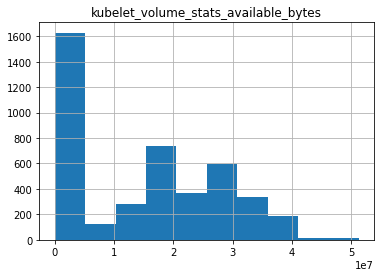

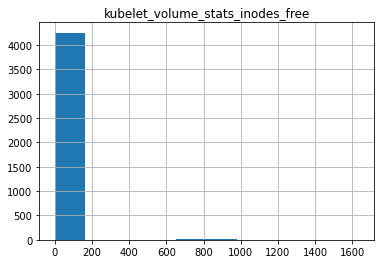

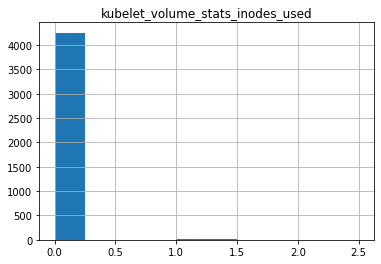

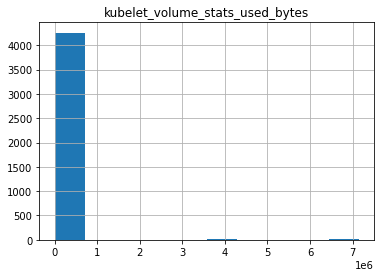

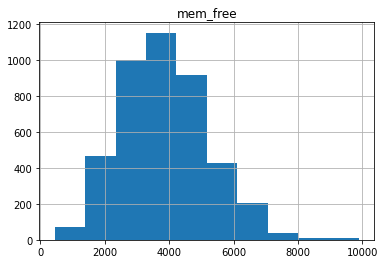

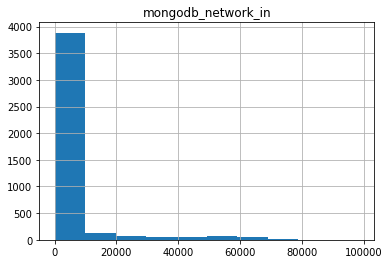

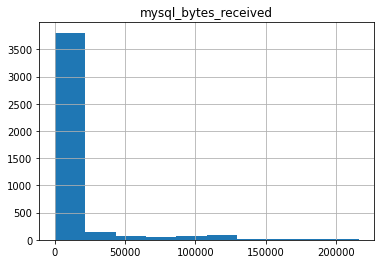

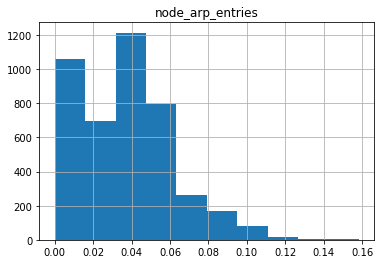

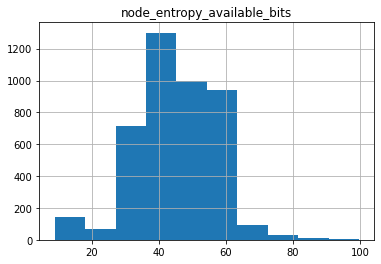

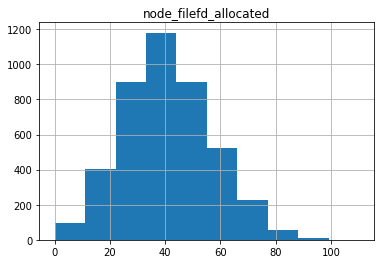

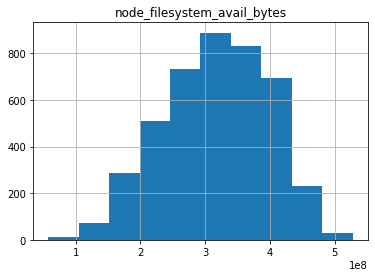

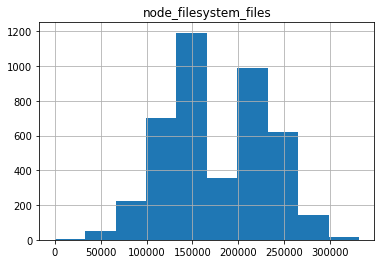

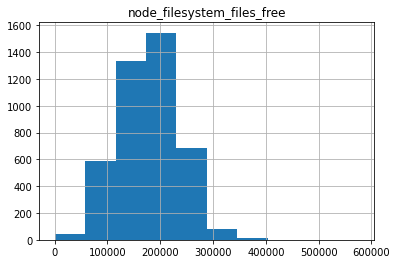

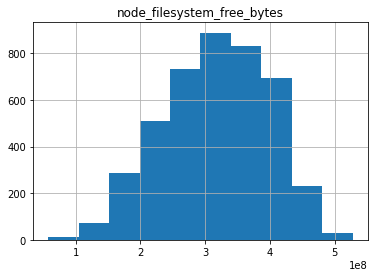

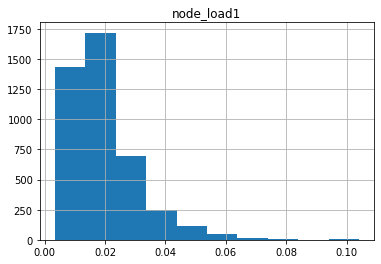

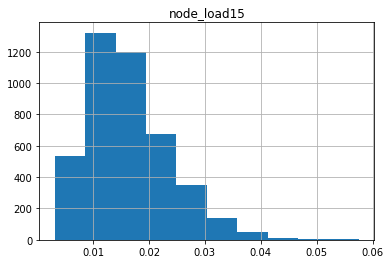

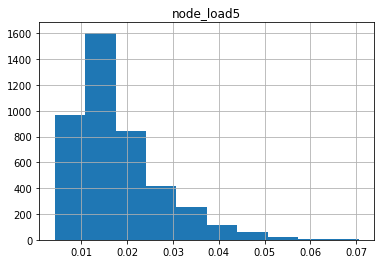

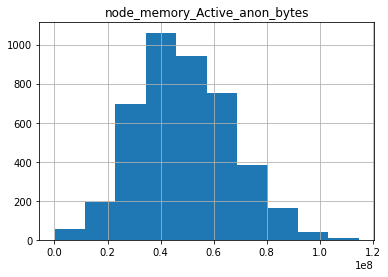

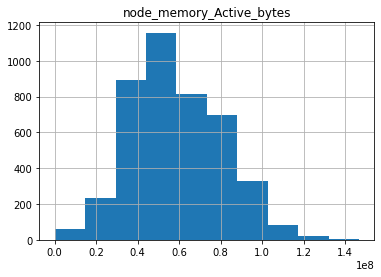

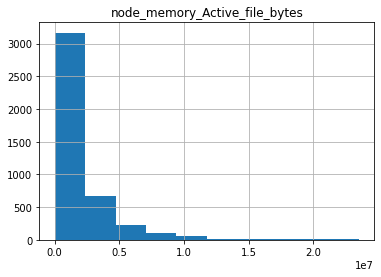

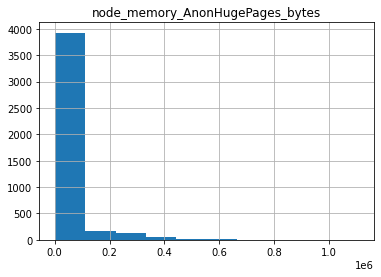

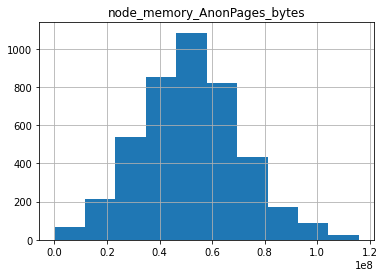

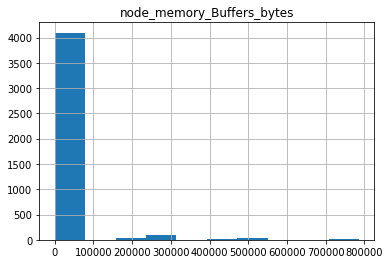

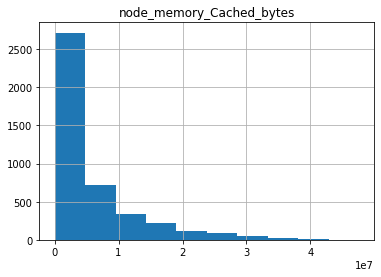

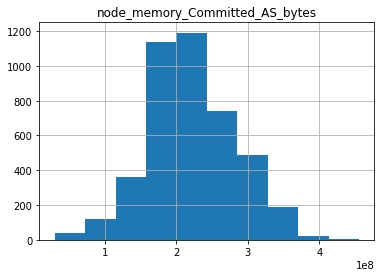

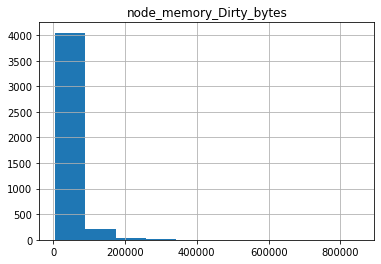

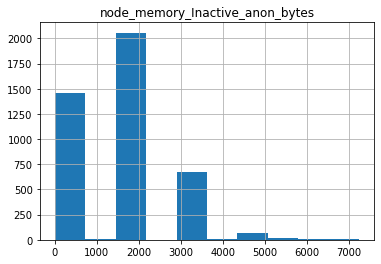

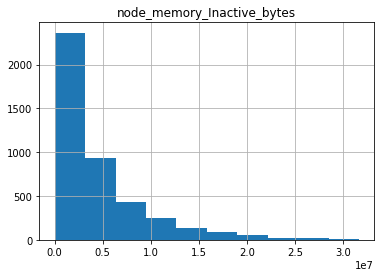

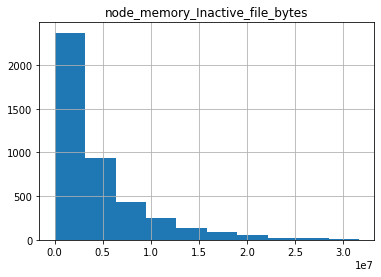

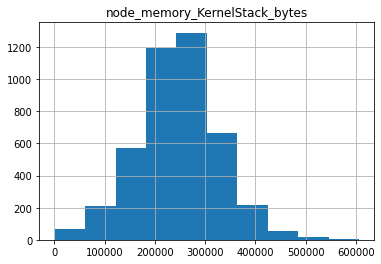

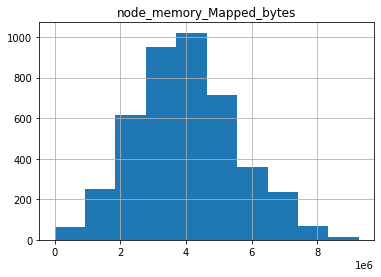

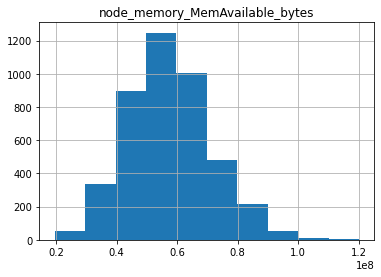

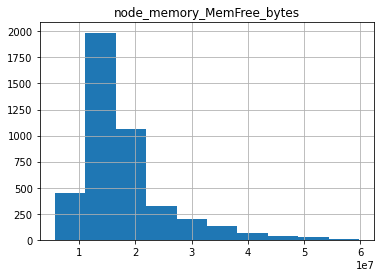

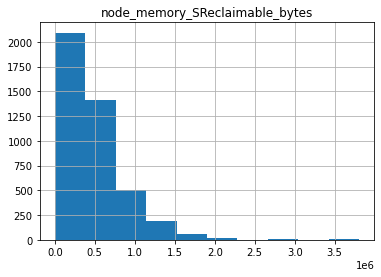

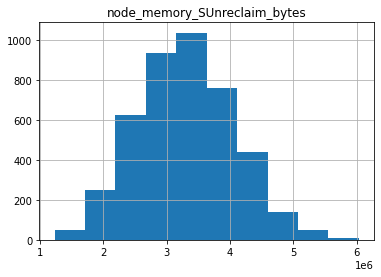

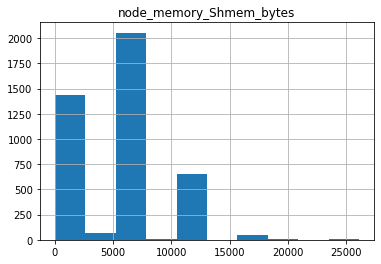

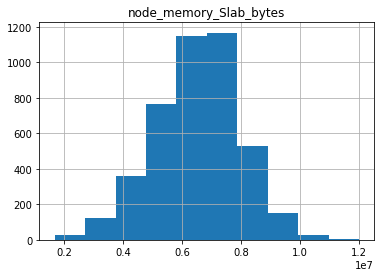

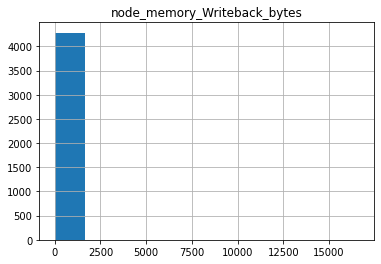

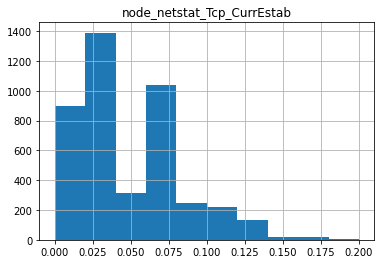

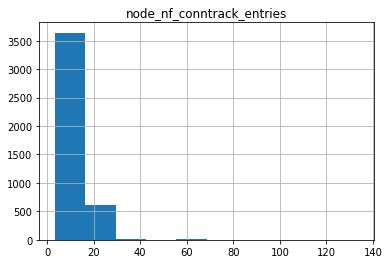

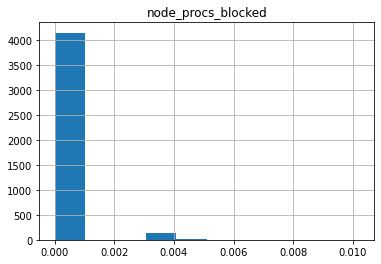

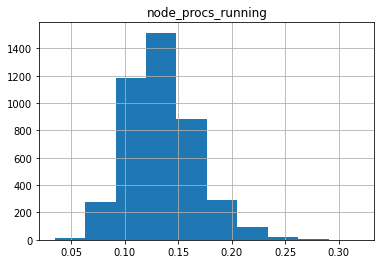

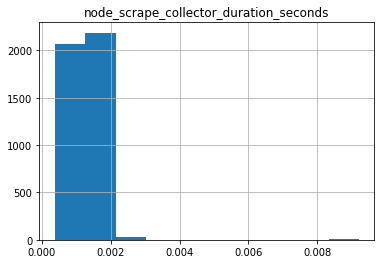

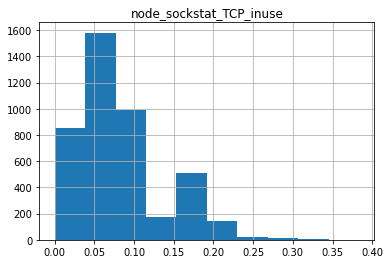

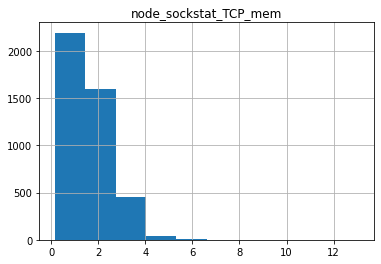

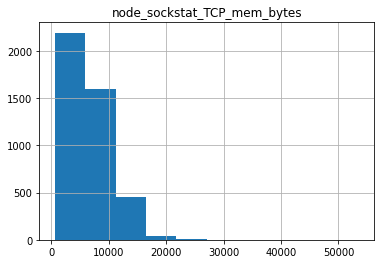

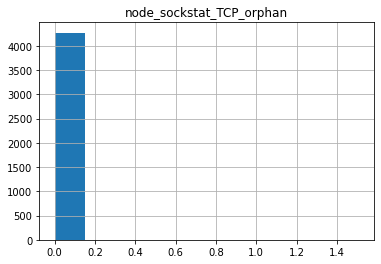

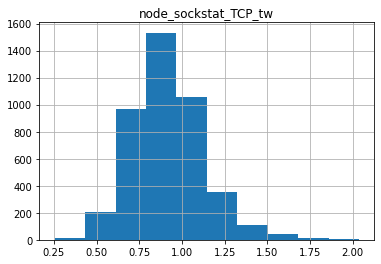

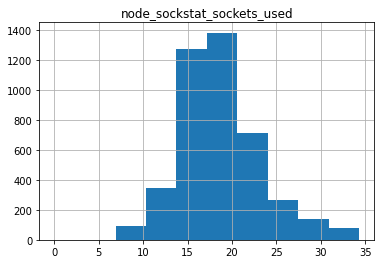

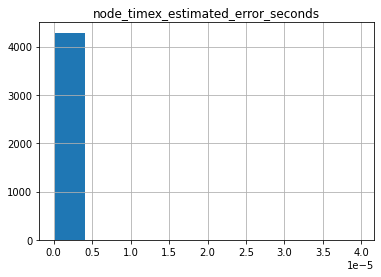

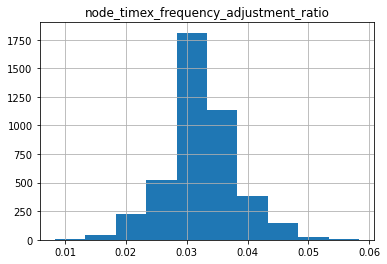

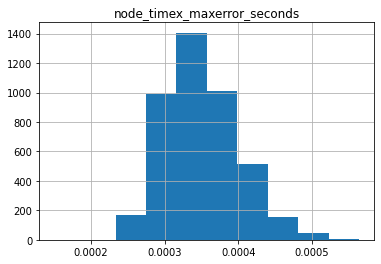

In [ ]:
for i in range(len(cols)):
  df_cm_plot[cols[i]].hist()
  plt.title(cols[i])
  plt.show()

Since the data is mostly skewed and some follow gaussian curve, the best approach is to use ffill method. Ffill method uses forward by the value in previous column in the same row.

In [170]:
df_cm=df_cm.fillna(method='ffill')  #Using fillna method to fill the NaN values

While doing the fillna, 'kubelet_pod_worker_duration_bucket' attribute have NaN values and constant value 10. Ffill picks up the 'NaN' more often than the constant value which inhibits the dropping the 'NaN' values

In [173]:
df_cm['kubelet_pod_worker_duration_bucket'].fillna(int(df_cm['kubelet_pod_worker_duration_bucket'].mean()), inplace=True)

In [175]:
df_cm.isna().any() #Checking for any NaN values after interpolation

timestamp                                                      False
apiserver_current_inflight_requests                            False
apiserver_request_latencies_summary                            False
apiserver_response_sizes_sum                                   False
apiserver_storage_transformation_latencies_microseconds_sum    False
aws_cpu_utilization                                            False
aws_ec2_cpuutilization_average                                 False
aws_ec2_network_out_average                                    False
aws_network_out                                                False
cgroup_manager_operation_rate                                  False
container_cpu_cfs_throttled_seconds_total                      False
container_fs_inodes_free                                       False
container_fs_usage_bytes                                       False
container_fs_writes_total                                      False
container_memory_cache            

# Data Preprocessing

While exploring , some of the columns have values have large data distribution. Using Standard Scaler, we are trying to remove the variance imposed by one of the attributes to the other which might cause feature dominance and inhibit the learning process for model


In [176]:
large_val_col=['apiserver_response_sizes_sum','aws_ec2_network_out_average','aws_network_out','container_fs_inodes_free','kafka_log_size_growth_rate','kafka_network_receive','kubelet_pleg_relist_interval_microseconds','mongodb_network_in','mysql_bytes_received','node_filesystem_files','node_filesystem_avail_bytes','node_filesystem_free_bytes','node_memory_Active_anon_bytes', 'node_memory_Active_bytes',
       'node_memory_Active_file_bytes', 'node_memory_AnonHugePages_bytes',
       'node_memory_AnonPages_bytes', 'node_memory_Buffers_bytes',
       'node_memory_Cached_bytes', 'node_memory_Committed_AS_bytes',
       'node_memory_Dirty_bytes', 'node_memory_Inactive_anon_bytes',
       'node_memory_Inactive_bytes', 'node_memory_Inactive_file_bytes',
       'node_memory_KernelStack_bytes', 'node_memory_Mapped_bytes',
       'node_memory_MemAvailable_bytes', 'node_memory_MemFree_bytes',
       'node_memory_SReclaimable_bytes', 'node_memory_SUnreclaim_bytes',
       'node_memory_Shmem_bytes', 'node_memory_Slab_bytes',
       'node_memory_Writeback_bytes','node_sockstat_TCP_tw']

**Standardization**

In [177]:
from sklearn.preprocessing import StandardScaler
SC=StandardScaler()
SC.fit(df_cm[large_val_col])

StandardScaler()

In [178]:
from sklearn.model_selection import train_test_split

In [179]:
X=df_cm.iloc[:,1:-1]
y=df_cm.iloc[:,-1]

In [180]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder() #Encoding the target class
y=lb.fit_transform(y)

In [181]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2) #Splitting the data into 80:20 ratio

#Model 

Xgboost

In [182]:
import xgboost as xgb
from xgboost import XGBClassifier

In [183]:
model=XGBClassifier(max_depth = 8, scale_pos_weight=1)
model.fit(X_train,y_train)

XGBClassifier(max_depth=8, objective='multi:softprob')

In [184]:
pred=model.predict(X_test)

In [185]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [186]:
accuracy=accuracy_score(y_test,pred)
print(accuracy)

0.9674039580908033


In [187]:
rprt=classification_report(y_test,pred)

In [188]:
print(rprt)

              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.95      0.90      0.92       116
           2       0.97      0.98      0.98       100
           3       0.97      0.99      0.98       583
           4       0.98      0.96      0.97        50

    accuracy                           0.97       859
   macro avg       0.97      0.85      0.88       859
weighted avg       0.97      0.97      0.97       859



Random Forest Model

In [191]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100,max_depth=10)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [196]:
y_pred=model_rf.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
accuracy

0.9417927823050058

In [197]:
rprt=classification_report(y_test,y_pred)
print(rprt)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       1.00      0.81      0.90       116
           2       1.00      0.87      0.93       100
           3       0.92      1.00      0.96       583
           4       0.98      0.92      0.95        50

    accuracy                           0.94       859
   macro avg       0.78      0.72      0.75       859
weighted avg       0.93      0.94      0.94       859



In [195]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

Logistic Regression

In [198]:
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
print("Accuracy: ",accuracy)
rprt=classification_report(y_test,y_pred)
print(rprt)

Accuracy:  0.6845168800931315
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.46      0.32      0.38       116
           2       0.50      0.13      0.21       100
           3       0.72      0.91      0.80       583
           4       0.45      0.18      0.26        50

    accuracy                           0.68       859
   macro avg       0.43      0.31      0.33       859
weighted avg       0.64      0.68      0.64       859



Support Vector Machine

In [199]:
svc=SVC(kernel='rbf')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
print("Accuracy: ",accuracy)
rprt=classification_report(y_test,y_pred)
print(rprt)

Accuracy:  0.6786961583236322
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00       116
           2       0.00      0.00      0.00       100
           3       0.68      1.00      0.81       583
           4       0.00      0.00      0.00        50

    accuracy                           0.68       859
   macro avg       0.14      0.20      0.16       859
weighted avg       0.46      0.68      0.55       859



In [200]:
from tensorflow.keras.utils import to_categorical

In [201]:
lb.classes_

array(['CPU_BURN_KANBAN_API_GATEWAY', 'NETWORK_DELAY_KANBAN_API_GATEWAY',
       'NETWORK_DELAY_KANBAN_COMMAND_SERVICE', 'NORMAL',
       'POD_KILL_KANBAN_API_GATEWAY'], dtype=object)

In [202]:
y_train_1 = to_categorical(y_train, 5)
y_test_1 = to_categorical(y_test, 5)


Neural Network with one Hidden Layer

In [203]:
model=Sequential()
model.add(Dense(128, kernel_initializer="normal", input_dim=95, activation='relu'))
model.add(Dense(64, kernel_initializer ="normal", activation="relu"))
model.add(Dense(5, kernel_initializer="normal", activation="softmax"))

In [204]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 128)               12288     
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dense_44 (Dense)            (None, 5)                 325       
                                                                 
Total params: 20,869
Trainable params: 20,869
Non-trainable params: 0
_________________________________________________________________


In [206]:

model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])

history=model.fit(X_train,y_train_1, epochs=100, batch_size=50)

Epoch 1/100
69/69 [==============================] - 1s 2ms/step - loss: 128.7566 - accuracy: 0.6296
Epoch 2/100
69/69 [==============================] - 0s 2ms/step - loss: 1.4827 - accuracy: 0.6328
Epoch 3/100
69/69 [==============================] - 0s 2ms/step - loss: 1.1022 - accuracy: 0.6331
Epoch 4/100
69/69 [==============================] - 0s 2ms/step - loss: 1.1022 - accuracy: 0.6331
Epoch 5/100
69/69 [==============================] - 0s 2ms/step - loss: 1.1021 - accuracy: 0.6331
Epoch 6/100
69/69 [==============================] - 0s 2ms/step - loss: 1.1022 - accuracy: 0.6331
Epoch 7/100
69/69 [==============================] - 0s 2ms/step - loss: 1.1022 - accuracy: 0.6331
Epoch 8/100
69/69 [==============================] - 0s 2ms/step - loss: 1.1022 - accuracy: 0.6331
Epoch 9/100
69/69 [==============================] - 0s 2ms/step - loss: 1.1022 - accuracy: 0.6331
Epoch 10/100
69/69 [==============================] - 0s 2ms/step - loss: 1.1022 - accuracy: 0.6331
Epoch 1

# Model Verdict

      MODEL       Accuracy
1.   XGBoost :        96.74%
2.   Rand Forest Classifier : 94.1%
3.   Logistic Regression : 68.45%
4.   Support Vector Machine : 67.86%
5. Neural Network : 63.31%

We observe that the XGBoosts outperforms all the model. Since we see that there is a class imbalance, the model doesn't yields recall for class 0. This might cause the baisedness towards one class. We will follow up with the further tuning










# Correleation

From correleation, we are trying to figure out the attributes which are correleated to the other attributes. This will help us reduce dimension or elminate attribute which has higher correleation to the other attribute.

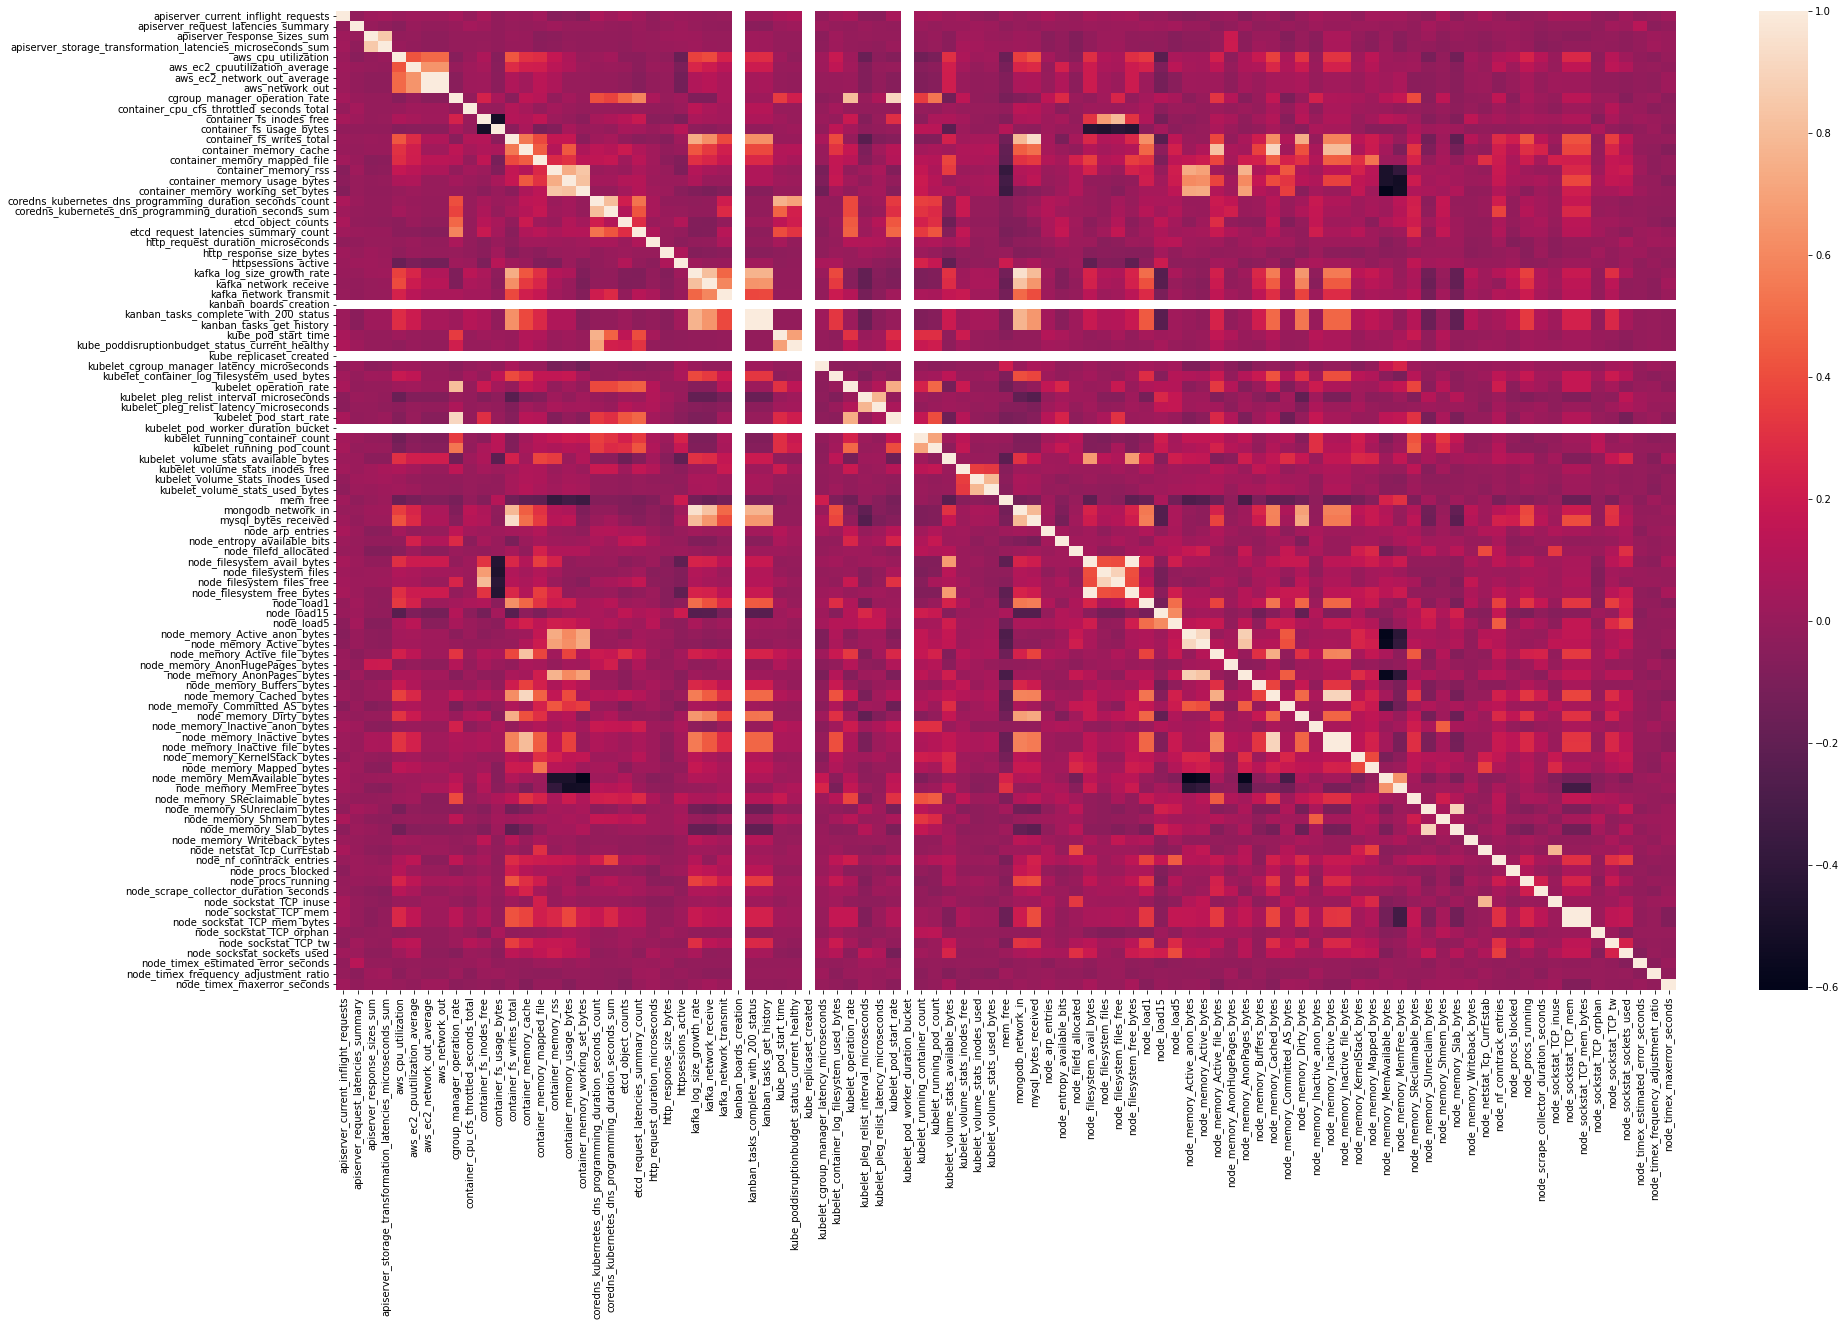

In [ ]:
plt.figure(figsize=(30,18))
sns.heatmap(corr)

From the correleation heatmap, we see that some of the attributes are highly correleated to each other. As of now, we will not drop any atrribute , as we have higher accuracy from the model.

Checking the class value distribution

In [ ]:
df_cm.status.value_counts()

NORMAL                                  2757
NETWORK_DELAY_KANBAN_API_GATEWAY         646
NETWORK_DELAY_KANBAN_COMMAND_SERVICE     500
POD_KILL_KANBAN_API_GATEWAY              310
CPU_BURN_KANBAN_API_GATEWAY               80
Name: status, dtype: int64

We see that Normal holds high number of instance with CPU_BURN_KANBAN_API_GATEWAY having the least. This causes the model to learn more from the Normal than the CPU_BURN_KANBAN_API_GATEWAY instances. Also the other instances for other attributes are considerbly less.


We will be using the over sampling method to equalize the number of instances for all classes to the same number. 

Using Imblearn's SMOTE to over sample the other classes

In [207]:
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced

In [219]:
oversample = SMOTE()
X_upsample, y_upsample = oversample.fit_resample(X_train, y_train) 
#We are upsampling from the training data. So we have original test data to see the model performance 

In [220]:
y_upsample.shape  #2757*5

(10870,)

In [221]:
X_train_ups,X_test_ups,y_train_ups,y_test_ups=train_test_split(X_upsample,y_upsample,test_size=0.2)

Training XGBoost on the upsample data

In [222]:
model=XGBClassifier(max_depth = 8, scale_pos_weight=1)
model.fit(X_train_ups,y_train_ups)

XGBClassifier(max_depth=8, objective='multi:softprob')

In [226]:
y_pred=model.predict(X_test_ups)
accuracy=accuracy_score(y_test_ups,y_pred)
print("Accuracy: ",accuracy)
rprt=classification_report(y_test_ups,y_pred)
print(rprt)

Accuracy:  0.9926402943882244
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       439
           1       0.99      0.99      0.99       431
           2       1.00      1.00      1.00       421
           3       0.99      0.98      0.99       430
           4       1.00      1.00      1.00       453

    accuracy                           0.99      2174
   macro avg       0.99      0.99      0.99      2174
weighted avg       0.99      0.99      0.99      2174



**We see that the our precision and recall have fairly been improved with great accuracy**

**Testing on Original data**

In [224]:
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
print("Accuracy: ",accuracy)
rprt=classification_report(y_test,y_pred)
print(rprt)

Accuracy:  0.9650756693830035
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.95      0.90      0.92       116
           2       0.96      0.95      0.95       100
           3       0.97      0.98      0.98       583
           4       0.98      0.96      0.97        50

    accuracy                           0.97       859
   macro avg       0.95      0.92      0.93       859
weighted avg       0.96      0.97      0.96       859



**Classifiaction repeort for oversampled data**

In [228]:
print(classification_report_imbalanced(y_test_ups,y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      1.00      0.99      1.00      0.99       439
          1       0.99      0.99      1.00      0.99      0.99      0.99       431
          2       1.00      1.00      1.00      1.00      1.00      1.00       421
          3       0.99      0.98      1.00      0.99      0.99      0.98       430
          4       1.00      1.00      1.00      1.00      1.00      0.99       453

avg / total       0.99      0.99      1.00      0.99      1.00      0.99      2174



# Final Verdict

We see that the after oversampling the data and deploying it on XGBoost model, our model performs achieves great performance both on the oversampled test data and original test data, thereby improving the precision and recall for all classes.

In [ ]:
x-min/max-min

In [62]:
import numpy as np
def normalizer(a):
  a=np.array(a)
  print(a)
  sh=a.shape
  b=np.transpose(a)
  #print(b)
  #print(sh[0])
  for i in range(sh[0]):
    max_=max(b[i])
    min_=min(b[i])
    for j in range(sh[1]):
      print((b[i][j]-min_)/(max_-min_))

In [63]:
a=[[1,2,4],[5,6,7],[8,10,11]]

In [64]:
normalizer(a)

[[ 1  2  4]
 [ 5  6  7]
 [ 8 10 11]]
0.0
0.5714285714285714
1.0
0.0
0.5
1.0
0.0
0.42857142857142855
1.0
